In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load gas line map NGC4298_gas_BIN_maps.fits 
gas_path = Path('NGC4298_gas_BIN_maps_extended.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    V_STARS2 = hdul['V_STARS2'].data
    SIGMA_STARS2 = hdul['SIGMA_STARS2'].data
    HB4861_FLUX = hdul['HB4861_FLUX'].data
    HB4861_FLUX_ERR = hdul['HB4861_FLUX_ERR'].data
    HA6562_FLUX = hdul['HA6562_FLUX'].data
    HA6562_FLUX_ERR = hdul['HA6562_FLUX_ERR'].data
    OIII5006_FLUX = hdul['OIII5006_FLUX'].data
    OIII5006_FLUX_ERR = hdul['OIII5006_FLUX_ERR'].data
    NII6583_FLUX = hdul['NII6583_FLUX'].data
    NII6583_FLUX_ERR = hdul['NII6583_FLUX_ERR'].data
    SII6716_FLUX = hdul['SII6716_FLUX'].data
    SII6716_FLUX_ERR = hdul['SII6716_FLUX_ERR'].data
    SII6730_FLUX = hdul['SII6730_FLUX'].data
    SII6730_FLUX_ERR = hdul['SII6730_FLUX_ERR'].data
    gas_header = hdul[5].header
    hdul.close()

gas_header

Loading gas line map from NGC4298_gas_BIN_maps_extended.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1042                                                  
NAXIS2  =                  995                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.11231877588 / Pixel coordinate of reference point            
CRPIX2  =      435.42596878359 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

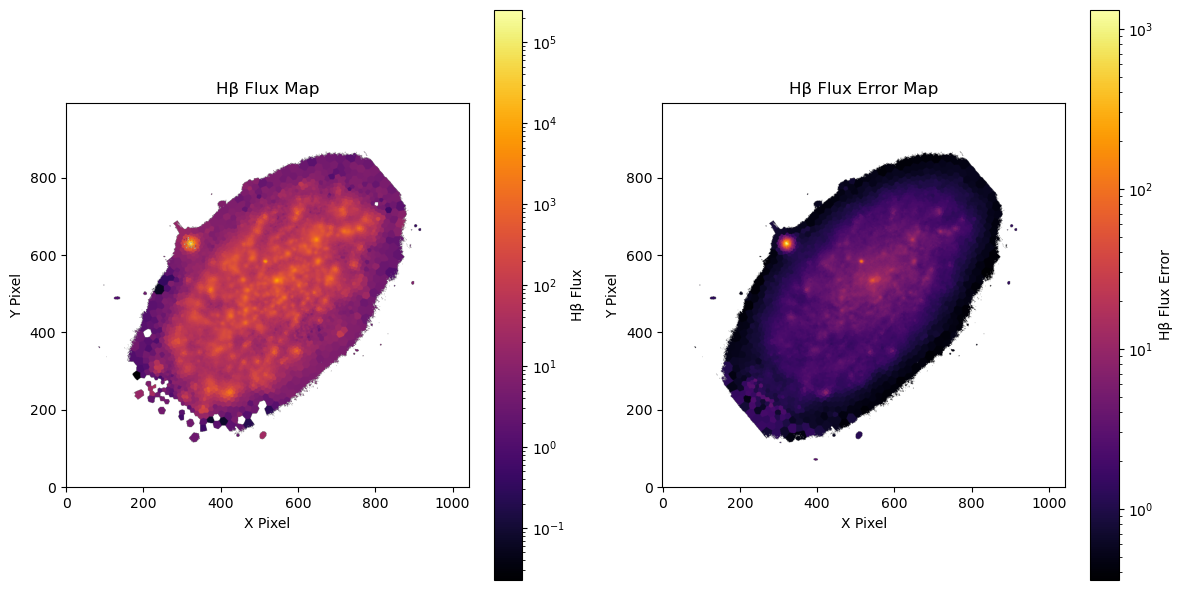

In [3]:
# Plot HB4861_FLUX and HB4861_FLUX_ERR map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(HB4861_FLUX, origin='lower', cmap='inferno', norm=LogNorm())
plt.colorbar(label='Hβ Flux')
plt.title('Hβ Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.subplot(1, 2, 2)
plt.imshow(HB4861_FLUX_ERR, origin='lower', cmap='inferno', norm=LogNorm())
plt.colorbar(label='Hβ Flux Error')
plt.title('Hβ Flux Error Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.tight_layout()
plt.show()


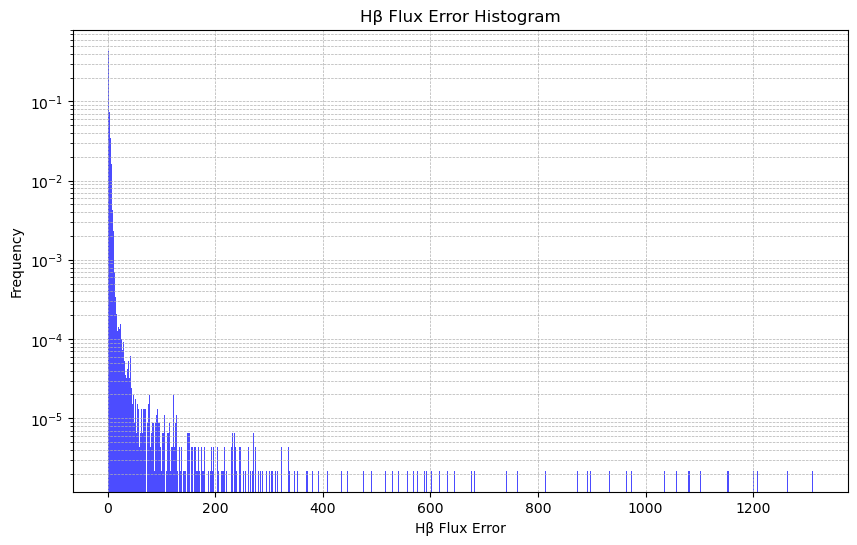

Mean Hβ Flux Error: 2.24
Median Hβ Flux Error: 1.40
Standard Deviation of Hβ Flux Error: 11.25


In [4]:
# Plot HB4861_FLUX_ERR histogram
plt.figure(figsize=(10, 6))
plt.hist(HB4861_FLUX_ERR[HB4861_FLUX_ERR > 0], 
         bins=1000, color='blue', alpha=0.7, density=True,)
plt.title('Hβ Flux Error Histogram')
plt.xlabel('Hβ Flux Error')
plt.ylabel('Frequency')
# plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print(f"Mean Hβ Flux Error: {np.mean(HB4861_FLUX_ERR[HB4861_FLUX_ERR > 0]):.2f}")
print(f"Median Hβ Flux Error: {np.median(HB4861_FLUX_ERR[HB4861_FLUX_ERR > 0]):.2f}")
print(f"Standard Deviation of Hβ Flux Error: {np.std(HB4861_FLUX_ERR[HB4861_FLUX_ERR > 0]):.2f}")

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/3227608733.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(HA6562_FLUX / HB4861_FLUX, origin='lower', cmap='viridis',
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/3227608733.py:3: RuntimeWarning: invalid value encountered in divide
  plt.imshow(HA6562_FLUX / HB4861_FLUX, origin='lower', cmap='viridis',


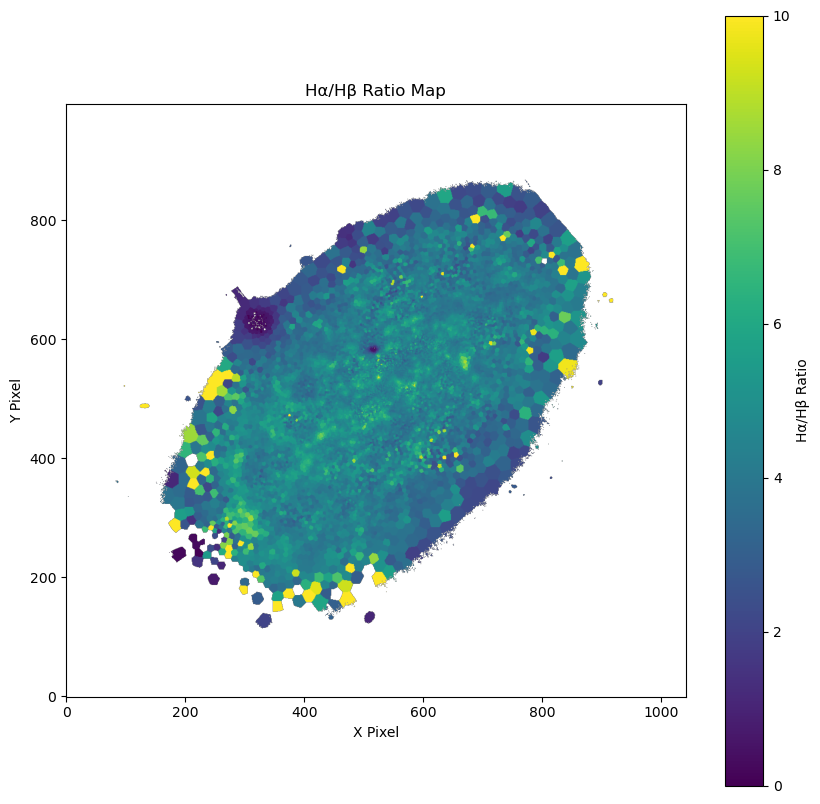

In [5]:
# Plot Ha/Hβ ratio map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX / HB4861_FLUX, origin='lower', cmap='viridis', 
           vmin=0, vmax=10)
plt.colorbar(label='Hα/Hβ Ratio')
plt.title('Hα/Hβ Ratio Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

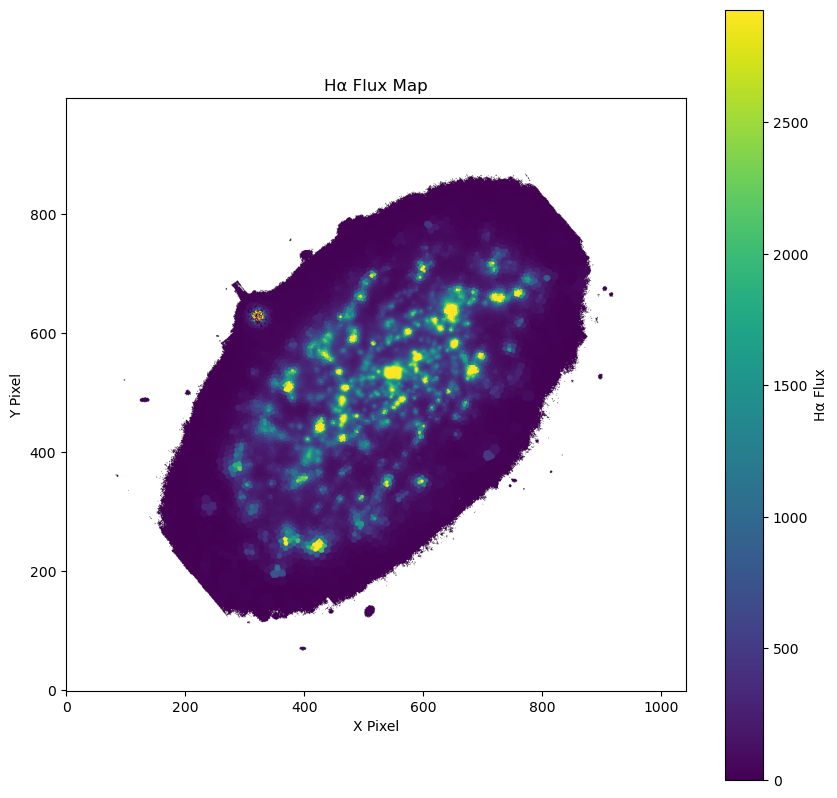

In [6]:
# Plot Ha6562_FLUX map
plt.figure(figsize=(10, 10))    
plt.imshow(HA6562_FLUX, origin='lower', cmap='viridis', 
           vmin=0, vmax=np.percentile(HA6562_FLUX[HA6562_FLUX > 0], 99))
plt.colorbar(label='Hα Flux')
plt.title('Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [7]:
HB4861_FLUX[HB4861_FLUX_ERR>1000]

array([ 65575.14715465,  79923.59774496, 176238.97810651,  70871.82144714,
        77616.3467291 , 250059.23588487, 227009.81254521, 167120.44365763,
        59016.8574068 ,  79990.95125898,  92201.4002787 ,  84141.39305365,
        59056.42291432], dtype='>f8')

In [8]:
# Apply a first cut of FLUX/ERR ≥ 5 on every line, 
# at least 22 to get min BD>2.86
# at least 15 to have all SF in BPT diagram
cut = 0
mask_HB = HB4861_FLUX / HB4861_FLUX_ERR >= cut
mask_HA = HA6562_FLUX / HA6562_FLUX_ERR >= cut
# Combine masks for both lines
mask_combined = mask_HB & mask_HA
# Apply the mask to the flux maps
HB4861_FLUX_cut = np.where(mask_combined, HB4861_FLUX, np.nan)
HA6562_FLUX_cut = np.where(mask_combined, HA6562_FLUX, np.nan)

# Balmer-decrement map – H α/H β (start with all spaxels).
BD = HA6562_FLUX_cut / HB4861_FLUX_cut
# ---- line ratios --------------------------------------------------
logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
logS2  = np.log10((SII6716_FLUX+SII6730_FLUX) / HA6562_FLUX)   # Σ[S II]/Hα
logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ         

mask_N2 = NII6583_FLUX / NII6583_FLUX_ERR >= cut
mask_S2 = (SII6716_FLUX + SII6730_FLUX) / (SII6716_FLUX_ERR + SII6730_FLUX_ERR) >= cut
mask_O3 = OIII5006_FLUX / OIII5006_FLUX_ERR >= cut
mask_combinedd = mask_combined & mask_N2 & mask_S2 & mask_O3

logN2_cut = np.where(mask_combinedd, logN2, np.nan)
logS2_cut = np.where(mask_combinedd, logS2, np.nan)
logO3_cut = np.where(mask_combinedd, logO3, np.nan)

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/2764862445.py:14: RuntimeWarning: divide by zero encountered in divide
  BD = HA6562_FLUX_cut / HB4861_FLUX_cut
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/2764862445.py:14: RuntimeWarning: invalid value encountered in divide
  BD = HA6562_FLUX_cut / HB4861_FLUX_cut
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/2764862445.py:16: RuntimeWarning: divide by zero encountered in divide
  logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/2764862445.py:16: RuntimeWarning: invalid value encountered in divide
  logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_65543/2764862445.py:16: RuntimeWarning: divide by zero encountered in log10
  logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b8

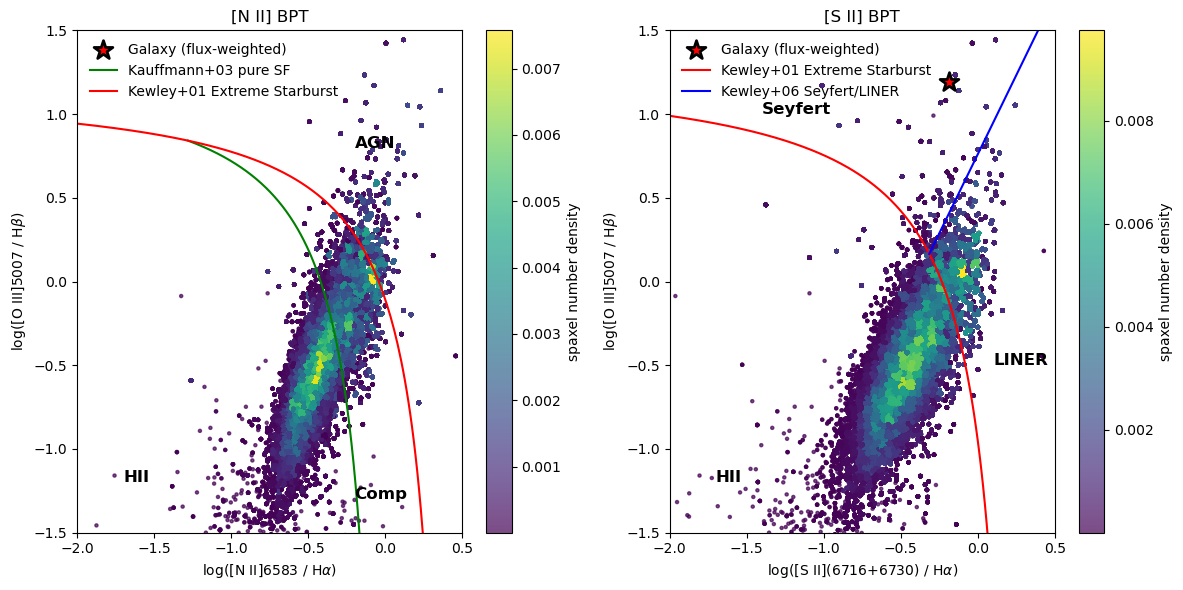

Galaxy flux-weighted representative points:
[N II] BPT: logN2 = 0.003, logO3 = 1.583
[S II] BPT: logS2 = -0.189, logO3 = 1.192
Number of spaxels in [N II] BPT regions:
HII: 182075, Comp: 112546, AGN: 61438
Number of spaxels in [S II] BPT regions:
HII: 235646, Seyfert: 26197, LINER: 85916


In [9]:
#  N II BPT -----------------------------------------
def kewley01_N2(x):   # max-starburst
    return 0.61/(x-0.47) + 1.19
def kauff03_N2(x):    # empirical SF upper envelope
    return 0.61/(x-0.05) + 1.30                            

#  S II BPT -----------------------------------------
def kewley01_S2(x):
    return 0.72/(x-0.32) + 1.30                           
def kewley06_Sy_LIN(x):   # Seyfert/LINER division
    return 1.89*x + 0.76        

# Calculate flux-weighted galaxy representative points
# Assuming you have a flux array (replace 'flux' with your actual flux variable name)
# If you don't have flux, you can use Ha_flux or another appropriate flux measurement
valid_mask_N2 = np.isfinite(logN2_cut) & np.isfinite(logO3_cut) 
valid_mask_S2 = np.isfinite(logS2_cut) & np.isfinite(logO3_cut) 

# Calculate flux-weighted representative points
galaxy_logN2 = np.log10(np.nansum(10**logN2_cut[valid_mask_N2] * 10**logN2_cut[valid_mask_N2]) / np.nansum(10**logN2_cut[valid_mask_N2]))
galaxy_logO3_N2 = np.log10(np.nansum(10**logO3_cut[valid_mask_N2] * 10**logO3_cut[valid_mask_N2]) / np.nansum(10**logO3_cut[valid_mask_N2]))
galaxy_logS2 = np.log10(np.nansum(10**logS2_cut[valid_mask_S2] * 10**logS2_cut[valid_mask_S2]) / np.nansum(10**logS2_cut[valid_mask_S2]))
galaxy_logO3_S2 = np.log10(np.nansum(10**logO3_cut[valid_mask_S2] * 10**logO3_cut[valid_mask_S2]) / np.nansum(10**logO3_cut[valid_mask_S2]))

fig, ax = plt.subplots(1, 2, figsize=(12,6))

# --- NII BPT -------------------------------------------------------
x = logN2_cut; y = logO3_cut
# Create a 2D histogram to get density information
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=100)
# Assign density values to each point
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[0].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[0], label='spaxel number density')

# Add flux-weighted galaxy point
ax[0].scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

xg = np.linspace((286-np.sqrt(2871561))/1100, 0.0, 200)
ax[0].plot(xg, kauff03_N2(xg), 'g-', lw=1.5, label='Kauffmann+03 pure SF')
xr = np.linspace(-2.0, 0.3, 200)
ax[0].plot(xr, kewley01_N2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
ax[0].set_xlabel(r'log([N II]6583 / H$\alpha$)')
ax[0].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[0].set_xlim(-2.0, 0.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_title('[N II] BPT')
ax[0].legend(frameon=False, loc='upper left')

# Add annotations for NII BPT
ax[0].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[0].text(-0.2, -1.3, 'Comp', fontsize=12, fontweight='bold')
ax[0].text(-0.2, 0.8, 'AGN', fontsize=12, fontweight='bold')

# --- SII BPT -------------------------------------------------------
x = logS2_cut; y = logO3_cut
# Create a 2D histogram for S II BPT
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=100)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[1].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[1], label='spaxel number density')

# Add flux-weighted galaxy point
ax[1].scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

ax[1].plot(xr, kewley01_S2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
xb = np.linspace((159-np.sqrt(105081))/525, 0.5, 200)
ax[1].plot(xb, kewley06_Sy_LIN(xb), 'b-', lw=1.5, label='Kewley+06 Seyfert/LINER')
ax[1].set_xlabel(r'log([S II](6716+6730) / H$\alpha$)')
ax[1].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[1].set_xlim(-2.0, 0.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].set_title('[S II] BPT')
ax[1].legend(frameon=False)

# Add annotations for SII BPT
ax[1].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[1].text(-1.4, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
ax[1].text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')

plt.tight_layout(); plt.show()

# Print galaxy representative points
print(f"Galaxy flux-weighted representative points:")
print(f"[N II] BPT: logN2 = {galaxy_logN2:.3f}, logO3 = {galaxy_logO3_N2:.3f}")
print(f"[S II] BPT: logS2 = {galaxy_logS2:.3f}, logO3 = {galaxy_logO3_S2:.3f}")

# Count the number of spaxels in each region
N2_HII = logO3 <= kauff03_N2(logN2)
N2_Comp = (logO3 > kauff03_N2(logN2)) & (logO3 <= kewley01_N2(logN2))
N2_AGN = logO3 > kewley01_N2(logN2)
S2_HII = logO3 <= kewley01_S2(logS2)
S2_Seyfert = (logO3 > kewley01_S2(logS2)) & (logO3 > kewley06_Sy_LIN(logS2))
S2_LINER = (logO3 > kewley01_S2(logS2)) & (logO3 <= kewley06_Sy_LIN(logS2))
# Count the number of spaxels in each region
N2_HII_count = np.sum(N2_HII)
N2_Comp_count = np.sum(N2_Comp)
N2_AGN_count = np.sum(N2_AGN)
S2_HII_count = np.sum(S2_HII)
S2_Seyfert_count = np.sum(S2_Seyfert)
S2_LINER_count = np.sum(S2_LINER)
print(f"Number of spaxels in [N II] BPT regions:")
print(f"HII: {N2_HII_count}, Comp: {N2_Comp_count}, AGN: {N2_AGN_count}")
print(f"Number of spaxels in [S II] BPT regions:")
print(f"HII: {S2_HII_count}, Seyfert: {S2_Seyfert_count}, LINER: {S2_LINER_count}")

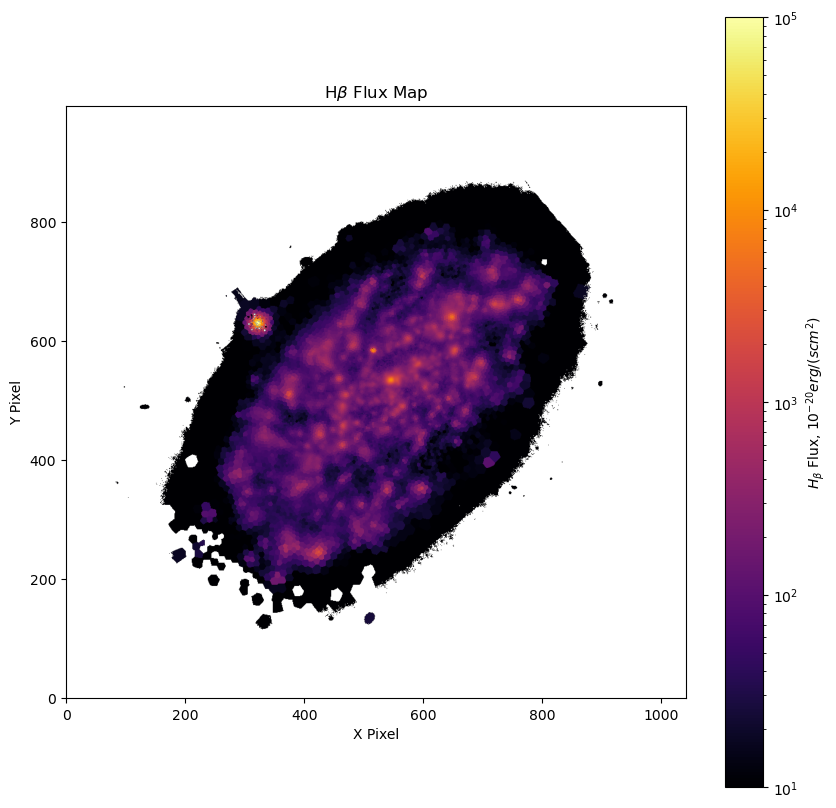

In [10]:
# Plot the Hbeta map
plt.figure(figsize=(10, 10))
plt.imshow(HB4861_FLUX, origin='lower', cmap='inferno', norm=LogNorm(vmin=10, vmax=1e5))
plt.colorbar(label=r'$H_\beta$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title(r'H$\beta$ Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

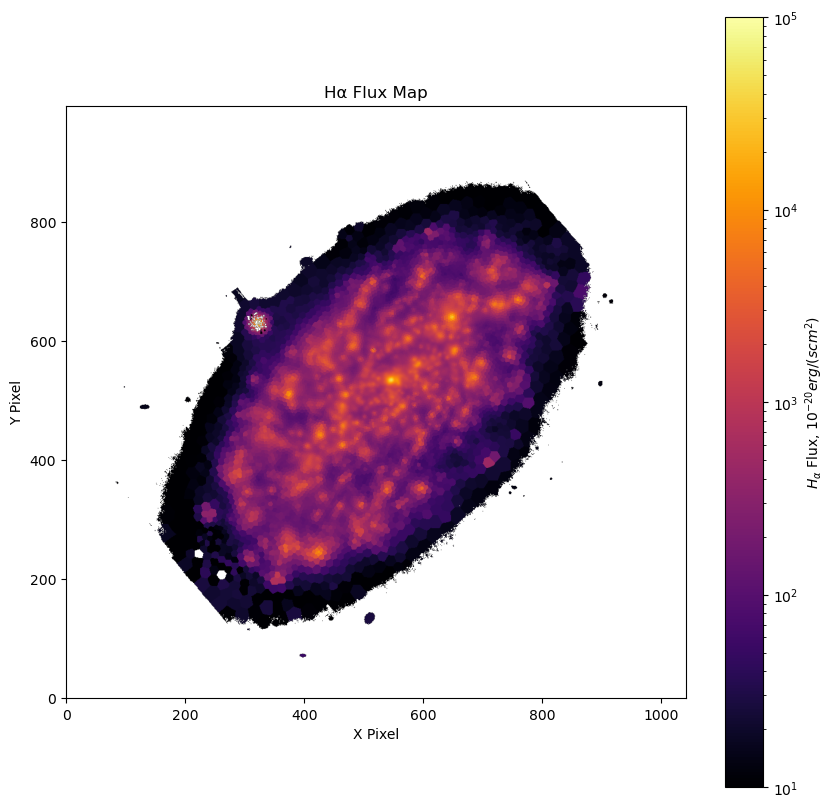

In [11]:
# Plot the Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=1e5))  # Logarithmic normalization
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [12]:
# Purely SF spaxels in both BPT diagram
mask_SF = (N2_HII+N2_Comp) & (S2_HII) #& (E_BV_BD > -0.5)  
# Apply the mask to the Halpha flux map
HA6562_FLUX_SF = np.where(mask_SF, HA6562_FLUX_cut, np.nan)
HB4861_FLUX_SF = np.where(mask_SF, HB4861_FLUX_cut, np.nan)
OIII5006_FLUX_SF = np.where(mask_SF, OIII5006_FLUX, np.nan)
NII6583_FLUX_SF = np.where(mask_SF, NII6583_FLUX, np.nan)
SII6716_FLUX_SF = np.where(mask_SF, SII6716_FLUX, np.nan)
SII6730_FLUX_SF = np.where(mask_SF, SII6730_FLUX, np.nan)
HA6562_FLUX_ERR_SF = np.where(mask_SF, HA6562_FLUX_ERR, np.nan)
HB4861_FLUX_ERR_SF = np.where(mask_SF, HB4861_FLUX_ERR, np.nan)
OIII5006_FLUX_ERR_SF = np.where(mask_SF, OIII5006_FLUX_ERR, np.nan)
NII6583_FLUX_ERR_SF = np.where(mask_SF, NII6583_FLUX_ERR, np.nan)
SII6716_FLUX_ERR_SF = np.where(mask_SF, SII6716_FLUX_ERR, np.nan)
SII6730_FLUX_ERR_SF = np.where(mask_SF, SII6730_FLUX_ERR, np.nan)
BD_SF = np.where(mask_SF, BD, np.nan)

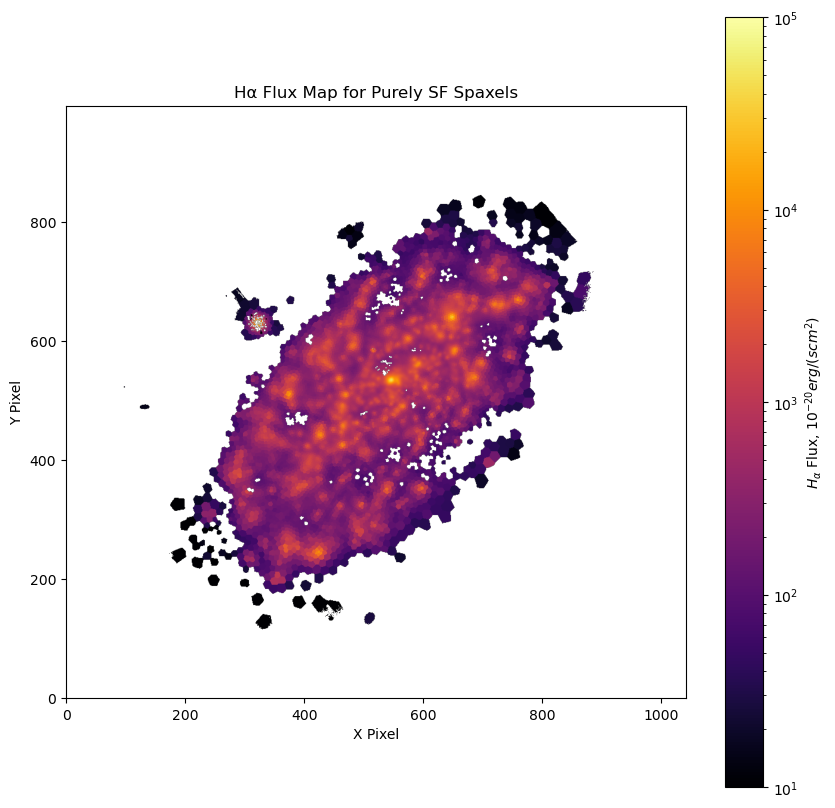

In [13]:
# Plot the Halpha map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

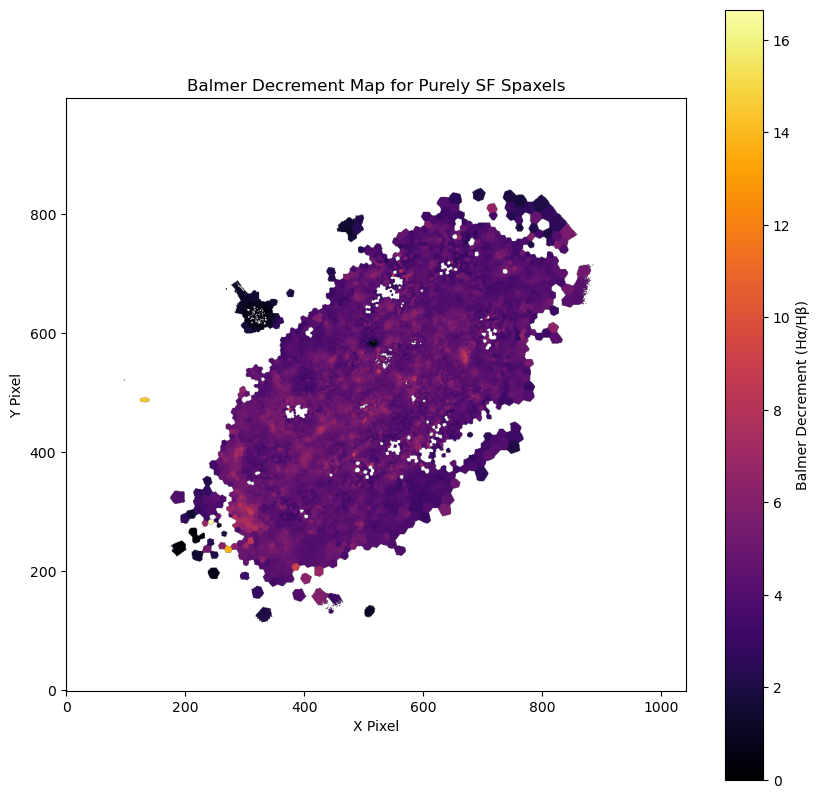

In [14]:
# Plot BD for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(BD_SF, origin='lower', cmap='inferno', 
           )
plt.colorbar(label='Balmer Decrement (Hα/Hβ)')
plt.title('Balmer Decrement Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

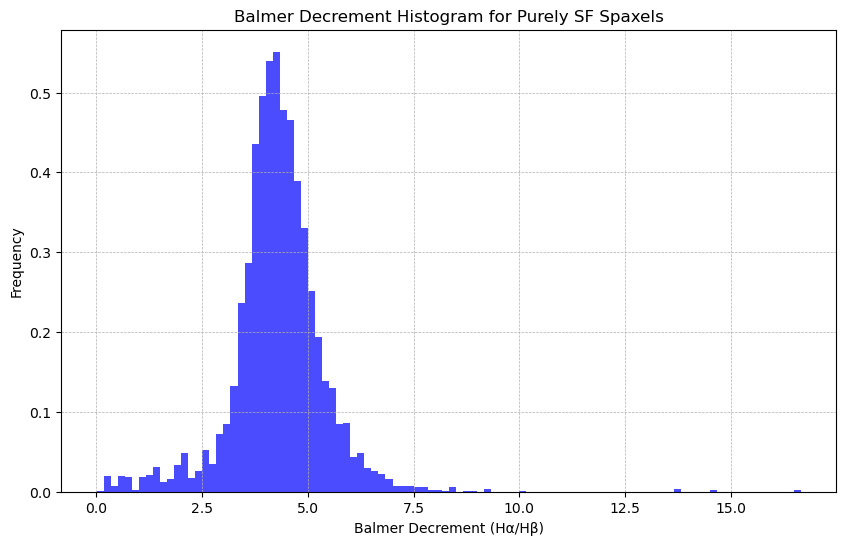

In [15]:
# Plot histogram of Balmer Decrement for purely SF spaxels
plt.figure(figsize=(10, 6))
plt.hist(BD_SF[BD_SF > 0], bins=100, color='blue', alpha=0.7, density=True)
plt.title('Balmer Decrement Histogram for Purely SF Spaxels')
plt.xlabel('Balmer Decrement (Hα/Hβ)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

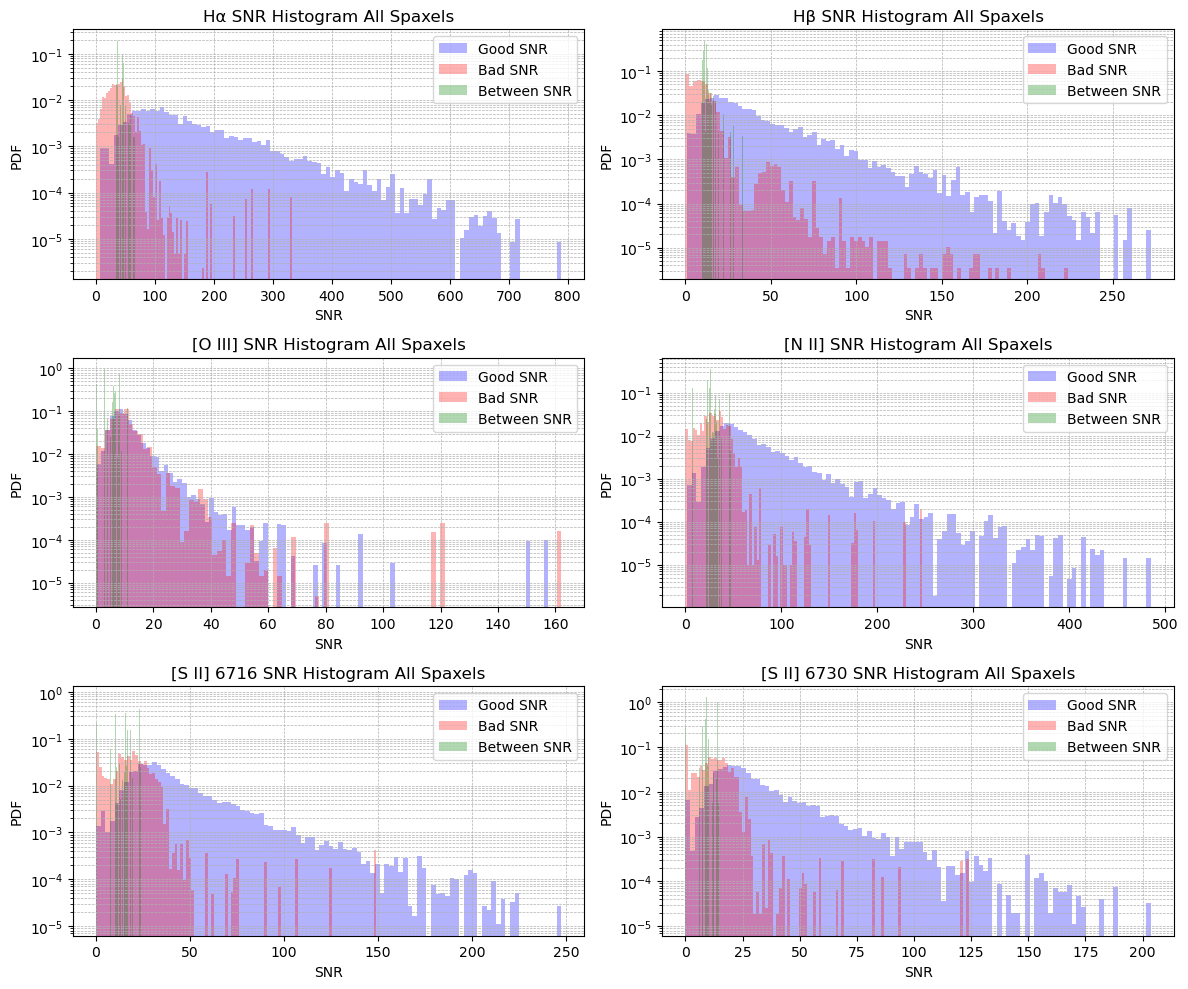

In [16]:
HA6562_FLUX_SNR = HA6562_FLUX/HA6562_FLUX_ERR
HB4861_FLUX_SNR = HB4861_FLUX/HB4861_FLUX_ERR
OIII5006_FLUX_SNR = OIII5006_FLUX/OIII5006_FLUX_ERR
NII6583_FLUX_SNR = NII6583_FLUX/NII6583_FLUX_ERR
SII6716_FLUX_SNR = SII6716_FLUX/SII6716_FLUX_ERR
SII6730_FLUX_SNR = SII6730_FLUX/SII6730_FLUX_ERR

threshold = 2.5  # BD threshold
good = BD_SF >= threshold
between = good & (BD_SF < 2.86)

HA6562_FLUX_SNR_good = HA6562_FLUX_SNR[good]
HB4861_FLUX_SNR_good = HB4861_FLUX_SNR[good]
OIII5006_FLUX_SNR_good = OIII5006_FLUX_SNR[good]
NII6583_FLUX_SNR_good = NII6583_FLUX_SNR[good]
SII6716_FLUX_SNR_good = SII6716_FLUX_SNR[good]
SII6730_FLUX_SNR_good = SII6730_FLUX_SNR[good]
HA6562_FLUX_SNR_bad = HA6562_FLUX_SNR[~good]
HB4861_FLUX_SNR_bad = HB4861_FLUX_SNR[~good]
OIII5006_FLUX_SNR_bad = OIII5006_FLUX_SNR[~good]
NII6583_FLUX_SNR_bad = NII6583_FLUX_SNR[~good]
SII6716_FLUX_SNR_bad = SII6716_FLUX_SNR[~good]
SII6730_FLUX_SNR_bad = SII6730_FLUX_SNR[~good]

HA6562_FLUX_SNR_between = HA6562_FLUX_SNR[between]
HB4861_FLUX_SNR_between = HB4861_FLUX_SNR[between]
OIII5006_FLUX_SNR_between = OIII5006_FLUX_SNR[between]
NII6583_FLUX_SNR_between = NII6583_FLUX_SNR[between]
SII6716_FLUX_SNR_between = SII6716_FLUX_SNR[between]
SII6730_FLUX_SNR_between = SII6730_FLUX_SNR[between]
# Plot SNR histograms for purely SF spaxels, each line (good+bad) each subplot
lines = {
    'Hα': (HA6562_FLUX_SNR_good, HA6562_FLUX_SNR_bad, HA6562_FLUX_SNR_between),
    'Hβ': (HB4861_FLUX_SNR_good, HB4861_FLUX_SNR_bad, HB4861_FLUX_SNR_between),
    '[O III]': (OIII5006_FLUX_SNR_good, OIII5006_FLUX_SNR_bad, OIII5006_FLUX_SNR_between),
    '[N II]': (NII6583_FLUX_SNR_good, NII6583_FLUX_SNR_bad, NII6583_FLUX_SNR_between),
    '[S II] 6716': (SII6716_FLUX_SNR_good, SII6716_FLUX_SNR_bad, SII6716_FLUX_SNR_between),
    '[S II] 6730': (SII6730_FLUX_SNR_good, SII6730_FLUX_SNR_bad, SII6730_FLUX_SNR_between)
}
plt.figure(figsize=(12, 10))
for i, (line, (snr_good, snr_bad, snr_between)) in enumerate(lines.items()):
    plt.subplot(3, 2, i + 1)
    plt.hist(snr_good, bins=100, color='blue', alpha=0.3, density=True, label='Good SNR')
    plt.hist(snr_bad, bins=100, color='red', alpha=0.3, density=True, label='Bad SNR')
    plt.hist(snr_between, bins=100, color='green', alpha=0.3, density=True, label='Between SNR')
    plt.title(f'{line} SNR Histogram All Spaxels')
    plt.xlabel('SNR')
    plt.ylabel('PDF')
    # plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
plt.tight_layout()
plt.show()


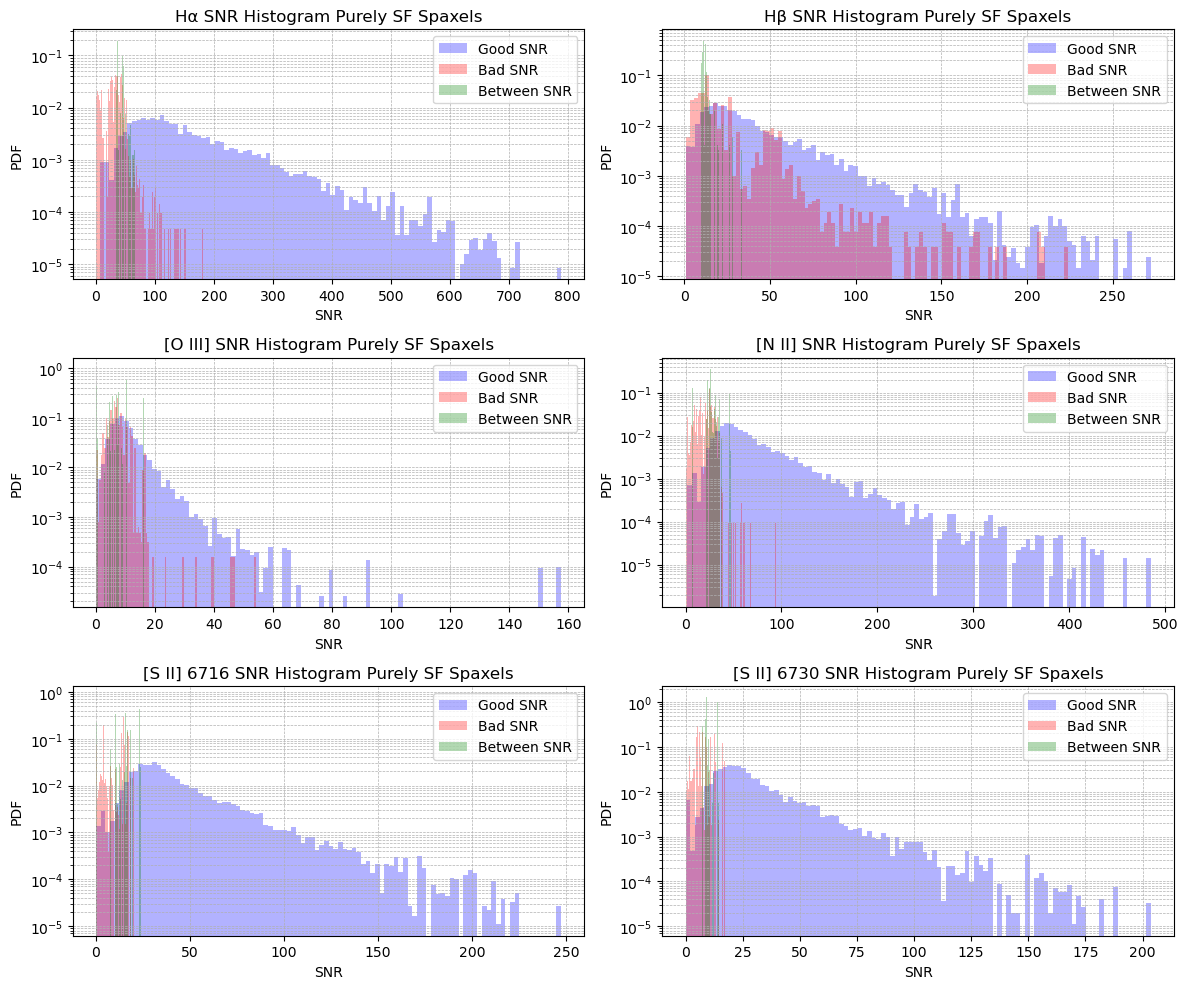

In [17]:
HA6562_FLUX_SF_SNR = HA6562_FLUX_SF/HA6562_FLUX_ERR_SF
HB4861_FLUX_SF_SNR = HB4861_FLUX_SF/HB4861_FLUX_ERR_SF
OIII5006_FLUX_SF_SNR = OIII5006_FLUX_SF/OIII5006_FLUX_ERR_SF
NII6583_FLUX_SF_SNR = NII6583_FLUX_SF/NII6583_FLUX_ERR_SF
SII6716_FLUX_SF_SNR = SII6716_FLUX_SF/SII6716_FLUX_ERR_SF
SII6730_FLUX_SF_SNR = SII6730_FLUX_SF/SII6730_FLUX_ERR_SF

HA6562_FLUX_SF_SNR_good = HA6562_FLUX_SF_SNR[good]
HB4861_FLUX_SF_SNR_good = HB4861_FLUX_SF_SNR[good]
OIII5006_FLUX_SF_SNR_good = OIII5006_FLUX_SF_SNR[good]
NII6583_FLUX_SF_SNR_good = NII6583_FLUX_SF_SNR[good]
SII6716_FLUX_SF_SNR_good = SII6716_FLUX_SF_SNR[good]
SII6730_FLUX_SF_SNR_good = SII6730_FLUX_SF_SNR[good]
HA6562_FLUX_SF_SNR_bad = HA6562_FLUX_SF_SNR[~good]
HB4861_FLUX_SF_SNR_bad = HB4861_FLUX_SF_SNR[~good]
OIII5006_FLUX_SF_SNR_bad = OIII5006_FLUX_SF_SNR[~good]
NII6583_FLUX_SF_SNR_bad = NII6583_FLUX_SF_SNR[~good]
SII6716_FLUX_SF_SNR_bad = SII6716_FLUX_SF_SNR[~good]
SII6730_FLUX_SF_SNR_bad = SII6730_FLUX_SF_SNR[~good]
HA6562_FLUX_SF_SNR_between = HA6562_FLUX_SF_SNR[between]
HB4861_FLUX_SF_SNR_between = HB4861_FLUX_SF_SNR[between]
OIII5006_FLUX_SF_SNR_between = OIII5006_FLUX_SF_SNR[between]
NII6583_FLUX_SF_SNR_between = NII6583_FLUX_SF_SNR[between]
SII6716_FLUX_SF_SNR_between = SII6716_FLUX_SF_SNR[between]
SII6730_FLUX_SF_SNR_between = SII6730_FLUX_SF_SNR[between]
# Plot SNR histograms for purely SF spaxels, each line (good+bad) each subplot  
lines = {
    'Hα': (HA6562_FLUX_SF_SNR_good, HA6562_FLUX_SF_SNR_bad, HA6562_FLUX_SF_SNR_between),
    'Hβ': (HB4861_FLUX_SF_SNR_good, HB4861_FLUX_SF_SNR_bad, HB4861_FLUX_SF_SNR_between),
    '[O III]': (OIII5006_FLUX_SF_SNR_good, OIII5006_FLUX_SF_SNR_bad, OIII5006_FLUX_SF_SNR_between),
    '[N II]': (NII6583_FLUX_SF_SNR_good, NII6583_FLUX_SF_SNR_bad, NII6583_FLUX_SF_SNR_between),
    '[S II] 6716': (SII6716_FLUX_SF_SNR_good, SII6716_FLUX_SF_SNR_bad, SII6716_FLUX_SF_SNR_between),
    '[S II] 6730': (SII6730_FLUX_SF_SNR_good, SII6730_FLUX_SF_SNR_bad, SII6730_FLUX_SF_SNR_between)
}
plt.figure(figsize=(12, 10))
for i, (line, (snr_good, snr_bad, snr_between)) in enumerate(lines.items()):
    plt.subplot(3, 2, i + 1)
    plt.hist(snr_good, bins=100, color='blue', alpha=0.3, density=True, label='Good SNR')
    plt.hist(snr_bad, bins=100, color='red', alpha=0.3, density=True, label='Bad SNR')
    plt.hist(snr_between, bins=100, color='green', alpha=0.3, density=True, label='Between SNR')
    plt.title(f'{line} SNR Histogram Purely SF Spaxels')
    plt.xlabel('SNR')
    plt.ylabel('PDF')
    # plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
plt.tight_layout()
plt.show()

In [18]:
BD_SF_good = np.where(good, BD_SF, np.nan)
BD_SF_bad = np.where(~good, BD_SF, np.nan)
BD_SF_between = np.where(between, BD_SF, np.nan)

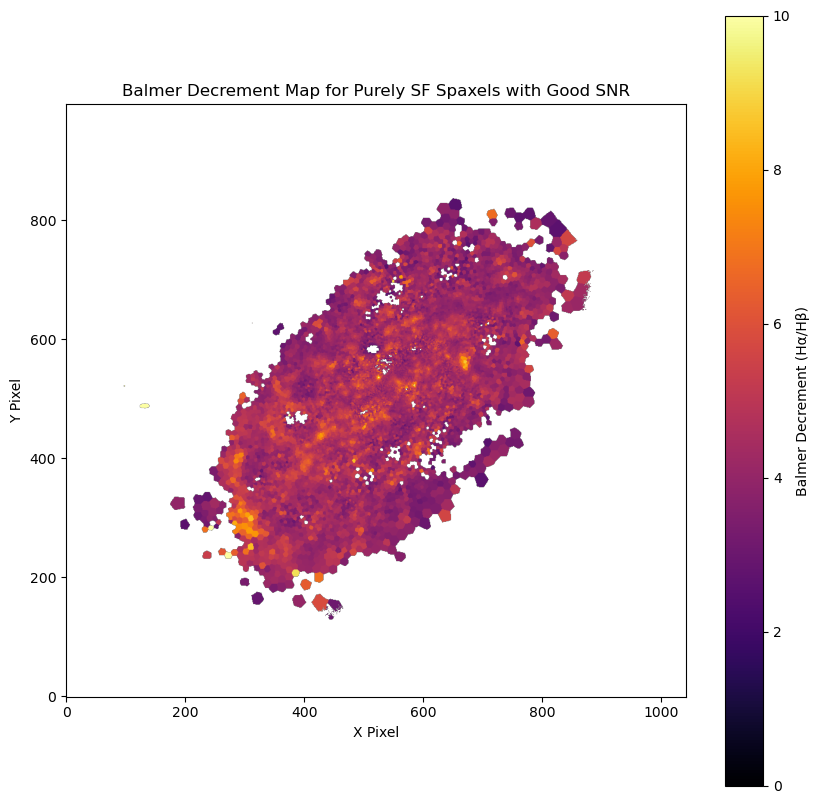

In [19]:
# Plot BD for purely SF spaxels with good SNR
plt.figure(figsize=(10, 10))
plt.imshow(BD_SF_good, origin='lower', cmap='inferno', 
           vmin=0, vmax=10)
plt.colorbar(label='Balmer Decrement (Hα/Hβ)')
plt.title('Balmer Decrement Map for Purely SF Spaxels with Good SNR')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

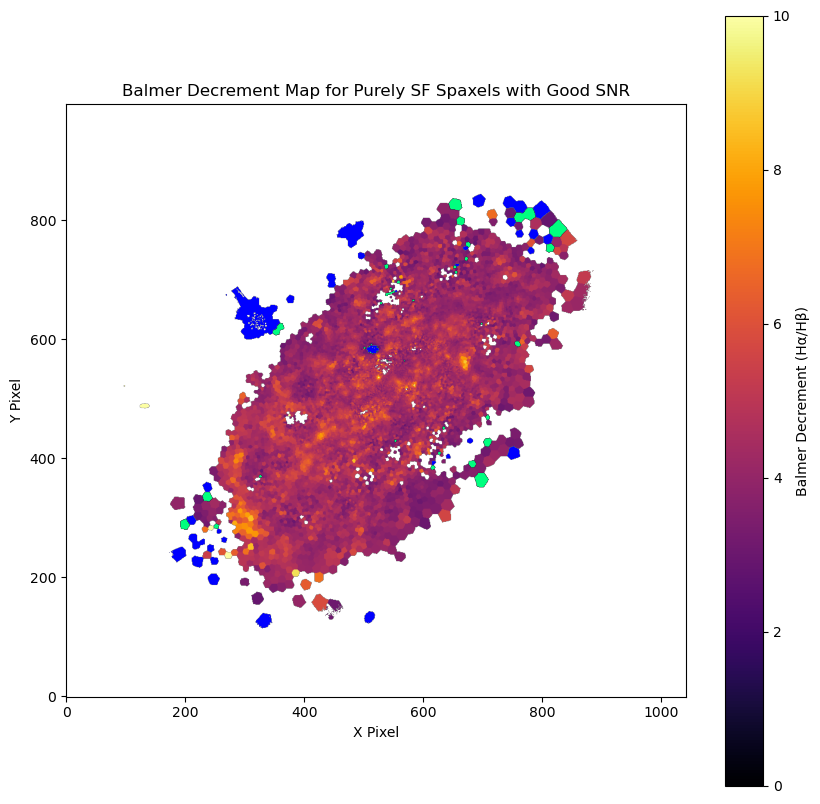

In [20]:
# Plot BD for purely SF spaxels with good SNR, 
# but label BD_SF_between as color green
plt.figure(figsize=(10, 10))
plt.imshow(BD_SF_good, origin='lower', cmap='inferno', 
           vmin=0, vmax=10)
plt.colorbar(label='Balmer Decrement (Hα/Hβ)')
plt.title('Balmer Decrement Map for Purely SF Spaxels with Good SNR')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.imshow(BD_SF_between, origin='lower', cmap='winter_r', 
           vmax=np.nanmin(BD_SF_between))
plt.imshow(BD_SF_bad, origin='lower', cmap='winter',
           vmin=np.nanmax(BD_SF_bad))
plt.show()

In [21]:
2.86*np.sqrt((np.nansum(HA6562_FLUX_SF*HA6562_FLUX_ERR_SF)/np.nansum(HA6562_FLUX_SF**2))**2 + (np.nansum(HB4861_FLUX_SF*HB4861_FLUX_ERR_SF)/np.nansum(HB4861_FLUX_SF**2))**2)

np.float64(0.027189562312544123)

In [22]:
2.86*np.sqrt((np.nansum(HA6562_FLUX*HA6562_FLUX_ERR)/np.nansum(HA6562_FLUX**2))**2 + (np.nansum(HB4861_FLUX*HB4861_FLUX_ERR)/np.nansum(HB4861_FLUX**2))**2)

np.float64(0.027878981611825674)

In [23]:
HA6562_FLUX_SF_good = np.where(good, HA6562_FLUX_SF, np.nan)
HB4861_FLUX_SF_good = np.where(good, HB4861_FLUX_SF, np.nan)
OIII5006_FLUX_SF_good = np.where(good, OIII5006_FLUX_SF, np.nan)
NII6583_FLUX_SF_good = np.where(good, NII6583_FLUX_SF, np.nan)
SII6716_FLUX_SF_good = np.where(good, SII6716_FLUX_SF, np.nan)
SII6730_FLUX_SF_good = np.where(good, SII6730_FLUX_SF, np.nan)
HA6562_FLUX_SF_bad = np.where(~good, HA6562_FLUX_SF, np.nan)
HB4861_FLUX_SF_bad = np.where(~good, HB4861_FLUX_SF, np.nan)
OIII5006_FLUX_SF_bad = np.where(~good, OIII5006_FLUX_SF, np.nan)
NII6583_FLUX_SF_bad = np.where(~good, NII6583_FLUX_SF, np.nan)
SII6716_FLUX_SF_bad = np.where(~good, SII6716_FLUX_SF, np.nan)
SII6730_FLUX_SF_bad = np.where(~good, SII6730_FLUX_SF, np.nan)
HA6562_FLUX_SF_between = np.where(between, HA6562_FLUX_SF, np.nan)
HB4861_FLUX_SF_between = np.where(between, HB4861_FLUX_SF, np.nan)
OIII5006_FLUX_SF_between = np.where(between, OIII5006_FLUX_SF, np.nan)
NII6583_FLUX_SF_between = np.where(between, NII6583_FLUX_SF, np.nan)
SII6716_FLUX_SF_between = np.where(between, SII6716_FLUX_SF, np.nan)
SII6730_FLUX_SF_between = np.where(between, SII6730_FLUX_SF, np.nan)
HA6562_FLUX_SF_poor = np.where(~good | between, HA6562_FLUX_SF, np.nan)
HB4861_FLUX_SF_poor = np.where(~good | between, HB4861_FLUX_SF, np.nan)
OIII5006_FLUX_SF_poor = np.where(~good | between, OIII5006_FLUX_SF, np.nan)
NII6583_FLUX_SF_poor = np.where(~good | between, NII6583_FLUX_SF, np.nan)
SII6716_FLUX_SF_poor = np.where(~good | between, SII6716_FLUX_SF, np.nan)
SII6730_FLUX_SF_poor = np.where(~good | between, SII6730_FLUX_SF, np.nan)

HA6562_FLUX_ERR_SF_good = np.where(good, HA6562_FLUX_ERR_SF, np.nan)
HB4861_FLUX_ERR_SF_good = np.where(good, HB4861_FLUX_ERR_SF, np.nan)
OIII5006_FLUX_ERR_SF_good = np.where(good, OIII5006_FLUX_ERR_SF, np.nan)
NII6583_FLUX_ERR_SF_good = np.where(good, NII6583_FLUX_ERR_SF, np.nan)
SII6716_FLUX_ERR_SF_good = np.where(good, SII6716_FLUX_ERR_SF, np.nan)
SII6730_FLUX_ERR_SF_good = np.where(good, SII6730_FLUX_ERR_SF, np.nan)
HA6562_FLUX_ERR_SF_bad = np.where(~good, HA6562_FLUX_ERR_SF, np.nan)
HB4861_FLUX_ERR_SF_bad = np.where(~good, HB4861_FLUX_ERR_SF, np.nan)
OIII5006_FLUX_ERR_SF_bad = np.where(~good, OIII5006_FLUX_ERR_SF, np.nan)
NII6583_FLUX_ERR_SF_bad = np.where(~good, NII6583_FLUX_ERR_SF, np.nan)
SII6716_FLUX_ERR_SF_bad = np.where(~good, SII6716_FLUX_ERR_SF, np.nan)
SII6730_FLUX_ERR_SF_bad = np.where(~good, SII6730_FLUX_ERR_SF, np.nan)
HA6562_FLUX_ERR_SF_between = np.where(between, HA6562_FLUX_ERR_SF, np.nan)
HB4861_FLUX_ERR_SF_between = np.where(between, HB4861_FLUX_ERR_SF, np.nan)
OIII5006_FLUX_ERR_SF_between = np.where(between, OIII5006_FLUX_ERR_SF, np.nan)
NII6583_FLUX_ERR_SF_between = np.where(between, NII6583_FLUX_ERR_SF, np.nan)
SII6716_FLUX_ERR_SF_between = np.where(between, SII6716_FLUX_ERR_SF, np.nan)
SII6730_FLUX_ERR_SF_between = np.where(between, SII6730_FLUX_ERR_SF, np.nan)
HA6562_FLUX_ERR_SF_poor = np.where(~good | between, HA6562_FLUX_ERR_SF, np.nan)
HB4861_FLUX_ERR_SF_poor = np.where(~good | between, HB4861_FLUX_ERR_SF, np.nan)
OIII5006_FLUX_ERR_SF_poor = np.where(~good | between, OIII5006_FLUX_ERR_SF, np.nan)
NII6583_FLUX_ERR_SF_poor = np.where(~good | between, NII6583_FLUX_ERR_SF, np.nan)
SII6716_FLUX_ERR_SF_poor = np.where(~good | between, SII6716_FLUX_ERR_SF, np.nan)
SII6730_FLUX_ERR_SF_poor = np.where(~good | between, SII6730_FLUX_ERR_SF, np.nan)

In [24]:
2.86*np.sqrt((np.nansum(HA6562_FLUX_SF_between*HA6562_FLUX_ERR_SF_between)/np.nansum(HA6562_FLUX_SF_between**2))**2 + (np.nansum(HB4861_FLUX_SF_between*HB4861_FLUX_ERR_SF_between)/np.nansum(HB4861_FLUX_SF_between**2))**2)

np.float64(0.15005291283820274)

In [25]:
((np.nansum(HA6562_FLUX_SF_between**2)/np.nansum(HA6562_FLUX_SF_between))/(np.nansum(HB4861_FLUX_SF_between**2)/np.nansum(HB4861_FLUX_SF_between)))*np.sqrt((np.nansum(HA6562_FLUX_SF_between*HA6562_FLUX_ERR_SF_between)/np.nansum(HA6562_FLUX_SF_between**2))**2 + (np.nansum(HB4861_FLUX_SF_between*HB4861_FLUX_ERR_SF_between)/np.nansum(HB4861_FLUX_SF_between**2))**2)

np.float64(0.14250780075110048)

In [26]:
2.86*np.sqrt((np.nansum(HA6562_FLUX_SF_poor*HA6562_FLUX_ERR_SF_poor)/np.nansum(HA6562_FLUX_SF_poor**2))**2 + (np.nansum(HB4861_FLUX_SF_poor*HB4861_FLUX_ERR_SF_poor)/np.nansum(HB4861_FLUX_SF_poor**2))**2)

np.float64(0.03294276871612268)

In [27]:
((np.nansum(HA6562_FLUX_SF_poor**2)/np.nansum(HA6562_FLUX_SF_poor))/(np.nansum(HB4861_FLUX_SF_poor**2)/np.nansum(HB4861_FLUX_SF_poor)))*np.sqrt((np.nansum(HA6562_FLUX_SF_poor*HA6562_FLUX_ERR_SF_poor)/np.nansum(HA6562_FLUX_SF_poor**2))**2 + (np.nansum(HB4861_FLUX_SF_poor*HB4861_FLUX_ERR_SF_poor)/np.nansum(HB4861_FLUX_SF_poor**2))**2)

np.float64(0.00786375274708247)

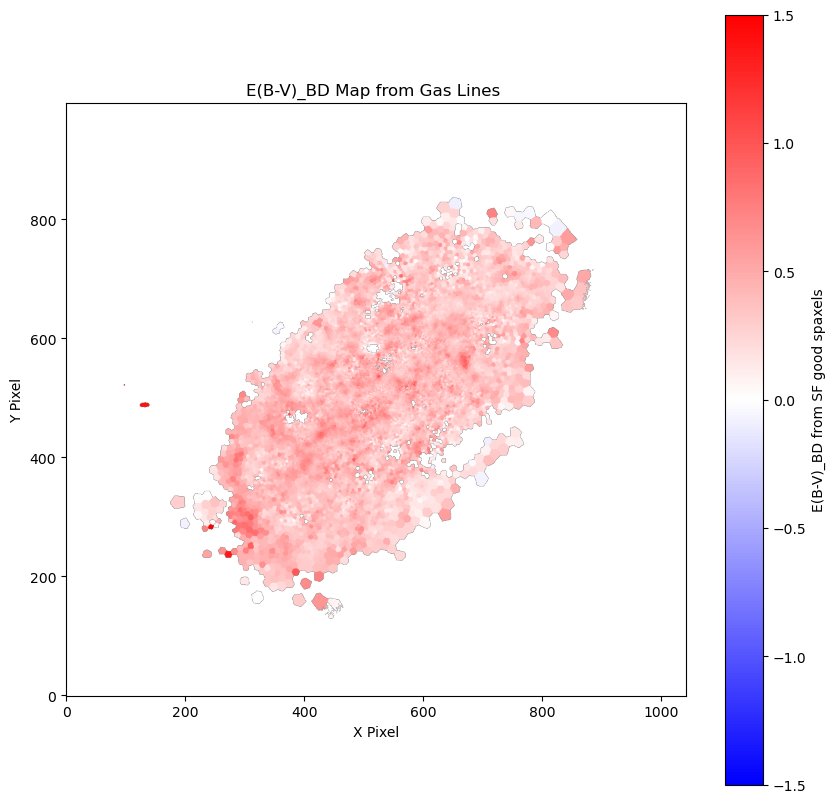

In [28]:
# O'Donnell (1994) update
# k_Hb = 3.609   # 4861 Å
# k_Ha = 2.535   # 6563 Å
# Calzetti (2000)
k_Hb = 4.598 
k_Ha = 3.325
R_int = 2.86

E_BV_BD = 2.5/(k_Hb - k_Ha) * np.log10( (HA6562_FLUX_SF_good/HB4861_FLUX_SF_good) / R_int )

plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(E_BV_BD, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V)_BD from SF good spaxels')
plt.title('E(B-V)_BD Map from Gas Lines ')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [29]:
# Manually set the negative E(B-V) values to zero
E_BV_BD[E_BV_BD < 0] = 0

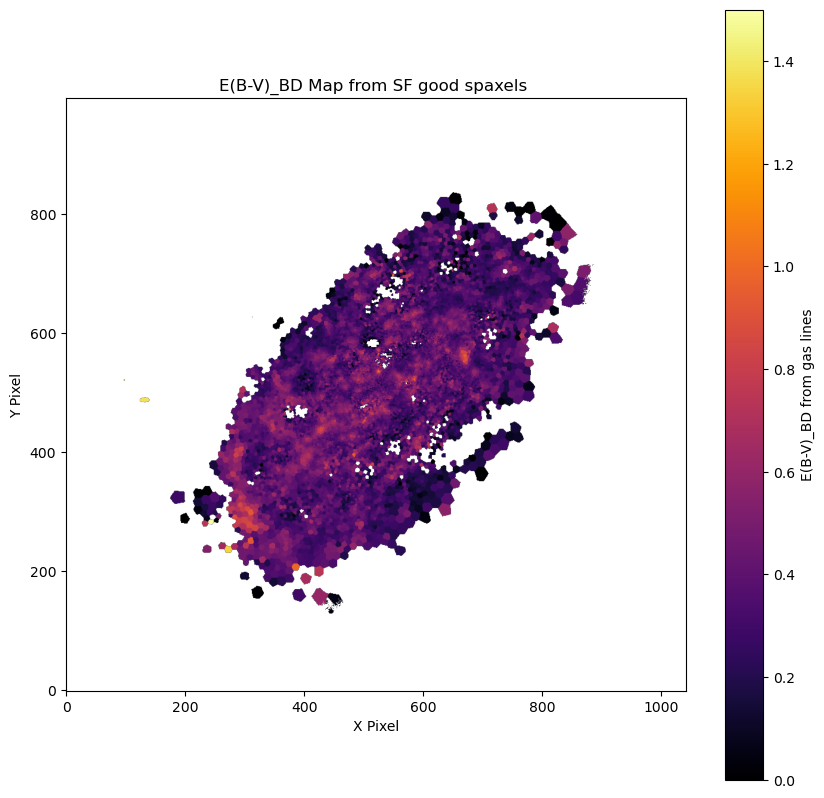

In [30]:
plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(E_BV_BD, origin='lower', cmap='inferno', vmin=0, vmax=1.5)
plt.colorbar(label='E(B-V)_BD from gas lines')
plt.title('E(B-V)_BD Map from SF good spaxels ')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

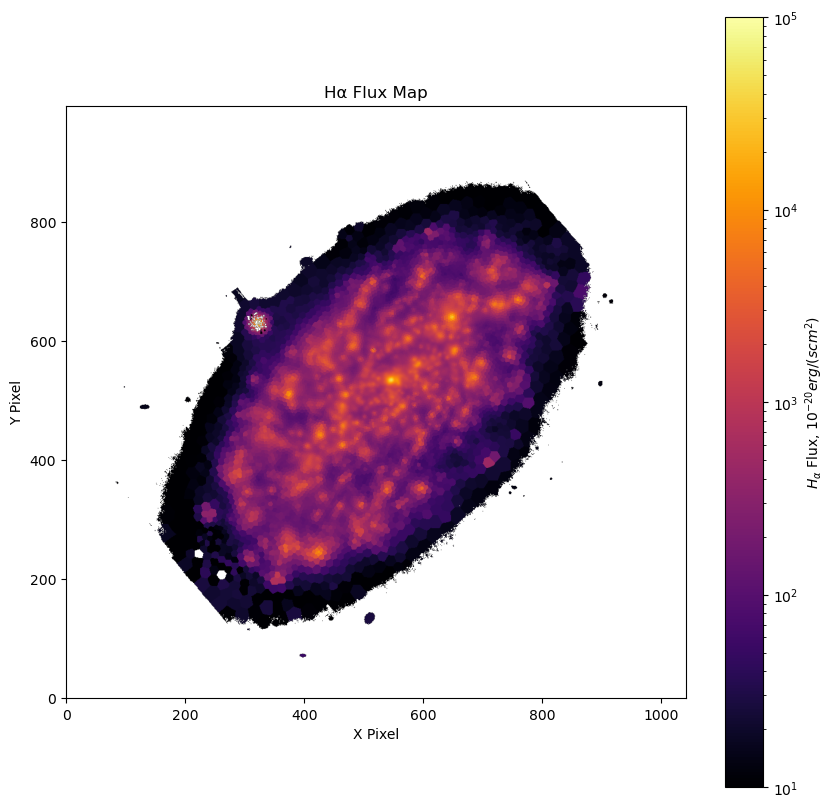

In [31]:
# Plot the Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=1e5))  # Logarithmic normalization
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

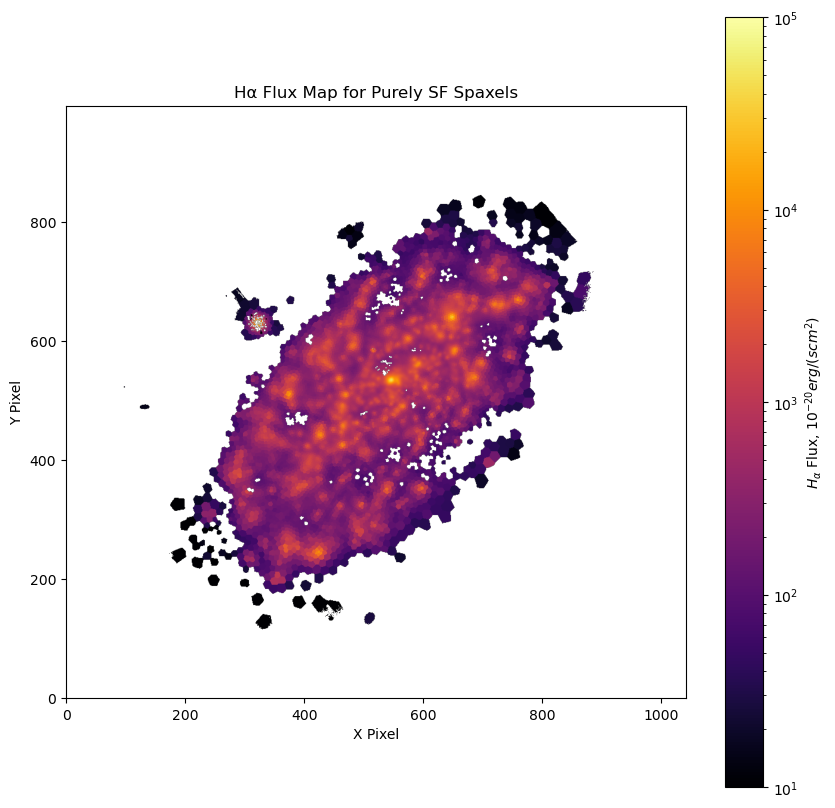

In [32]:
# Purely SF spaxels in both BPT diagram
mask_SF = (N2_HII+N2_Comp) & (S2_HII) #& (E_BV_BD > -0.5)  
# Apply the mask to the Halpha flux map
HA6562_FLUX_SF = np.where(mask_SF, HA6562_FLUX_cut, np.nan)
# Plot the Halpha map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

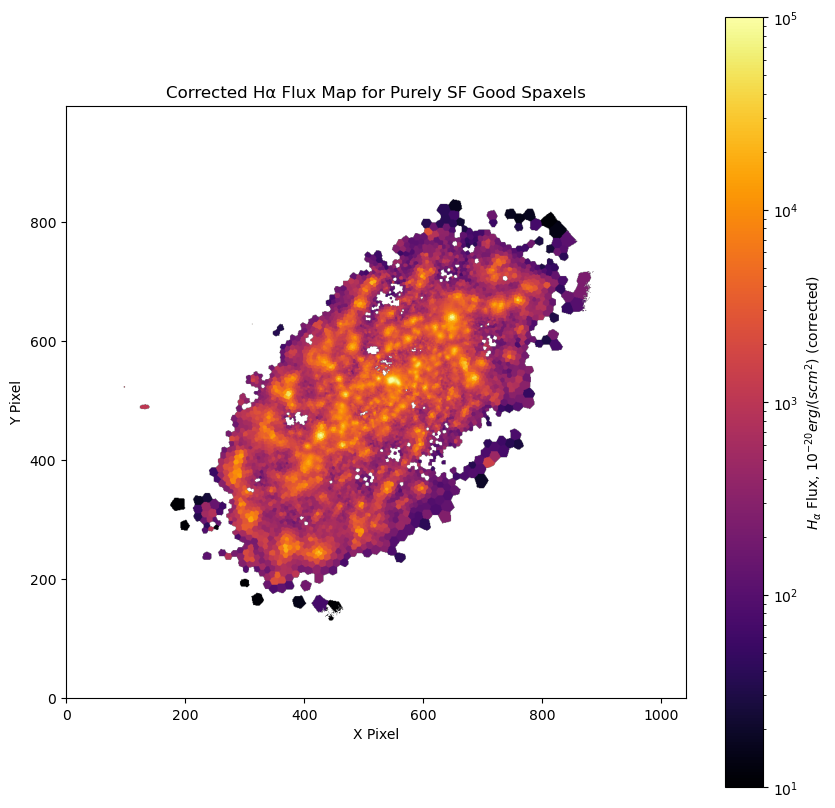

In [33]:
# Corrected Halpha map with E(B-V) from gas lines
HA6562_FLUX_SF_good_corr = HA6562_FLUX_SF_good * 10**(0.4 * k_Ha * E_BV_BD)
# Plot the corrected Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF_good_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$ (corrected)')
plt.title('Corrected Hα Flux Map for Purely SF Good Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

Total corrected Hα luminosity for purely SF good spaxels: 1.418e+41 erg / s erg/s


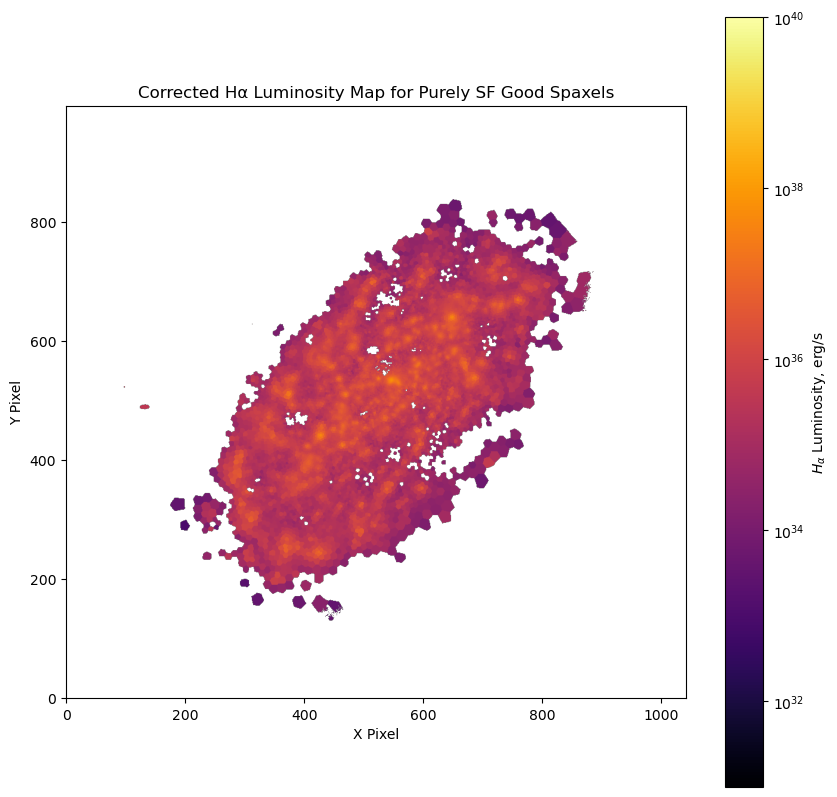

In [34]:
# Convert the corrected Halpha map ($10^{-20}erg/(s cm^2)$) to luminosity (erg/s)
def flux_to_luminosity(flux, distance=16.5):
    """
    Convert flux to luminosity.
    
    Parameters:
    flux : array-like
        Flux in erg/(s * Angstrom * cm^2).
    distance : float
        Distance in parsecs.
        
    Returns:
    luminosity : array-like
        Luminosity in erg/s.
    """
    return (flux*1e-20*u.erg/u.s/u.cm**2 * 4*np.pi*(distance*u.Mpc)**2).cgs

# Convert the corrected Halpha flux map to luminosity
HA6562_LUM_SF_good_corr = flux_to_luminosity(HA6562_FLUX_SF_good_corr)
total_HA6562_LUM_SF_good_corr = np.nansum(HA6562_LUM_SF_good_corr)
# Print the total luminosity
print(f"Total corrected Hα luminosity for purely SF good spaxels: {total_HA6562_LUM_SF_good_corr:.3e} erg/s")
# Plot the corrected Halpha luminosity map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_LUM_SF_good_corr.value, origin='lower', cmap='inferno',
           norm=LogNorm(vmin=1e31, vmax=1e40))  # Adjusted normalization for luminosity
plt.colorbar(label=r'$H_\alpha$ Luminosity, erg/s')
plt.title('Corrected Hα Luminosity Map for Purely SF Good Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

Total SFR for purely SF good spaxels: 0.707 M_sun/yr


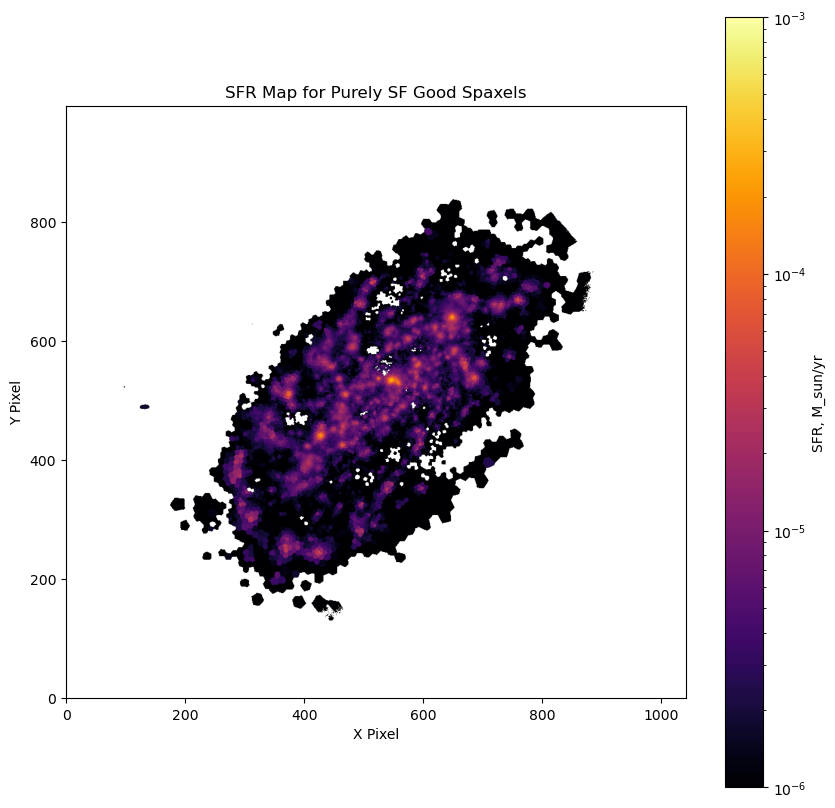

In [35]:
# SFR map from Halpha luminosity, using Calzetti 2007
def calzetti_sfr(luminosity):
    """
    Convert Halpha luminosity to SFR using Calzetti 2007.
    But it is assuming the Kroupa IMF, 
    so we need to times a coefficient to go to Chabrier IMF.
    
    Parameters:
    luminosity : array-like
        Halpha luminosity in erg/s.
        
    Returns:
    sfr : array-like
        Star formation rate in solar masses per year.
    """
    return 5.3e-42 * luminosity.cgs.value / 0.67 *0.63 # SFR in M_sun/yr

# Calculate SFR map from corrected Halpha luminosity
SFR_map_SF_good_corr = calzetti_sfr(HA6562_LUM_SF_good_corr)
# Calculate total SFR
total_SFR_SF_good_corr = calzetti_sfr(total_HA6562_LUM_SF_good_corr)
print(f"Total SFR for purely SF good spaxels: {total_SFR_SF_good_corr:.3f} M_sun/yr")
# Plot the SFR map
plt.figure(figsize=(10, 10))
plt.imshow(SFR_map_SF_good_corr, origin='lower', cmap='inferno',
           norm=LogNorm(vmin=1e-6, vmax=1e-3))  # Adjusted normalization for SFR
plt.colorbar(label='SFR, M_sun/yr')
plt.title('SFR Map for Purely SF Good Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [36]:
binning_path = Path('NGC4298_SPATIAL_BINNING_maps_extended.fits')
print(f"Loading kinematic map from {binning_path}")
with fits.open(binning_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")

print("All data loaded successfully!")


Loading kinematic map from NGC4298_SPATIAL_BINNING_maps_extended.fits
Filename: NGC4298_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (1042, 995)   float64   
  2  FLUX          1 ImageHDU        26   (1042, 995)   float64   
  3  SNR           1 ImageHDU        26   (1042, 995)   float64   
  4  SNRBIN        1 ImageHDU        26   (1042, 995)   float64   
  5  XBIN          1 ImageHDU        26   (1042, 995)   float64   
  6  YBIN          1 ImageHDU        26   (1042, 995)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (1042, 995)   float64   
  8  ML_R          1 ImageHDU        27   (1042, 995)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (1042, 995)   float64   
 10  LOGMASS_SURFACE_DENSITY    1 ImageHDU        27   (1042, 995)   float64   
 11  MAGNITUDE_R    1 ImageHDU        27   (1042, 995)   float64   
 12  MAGNITU

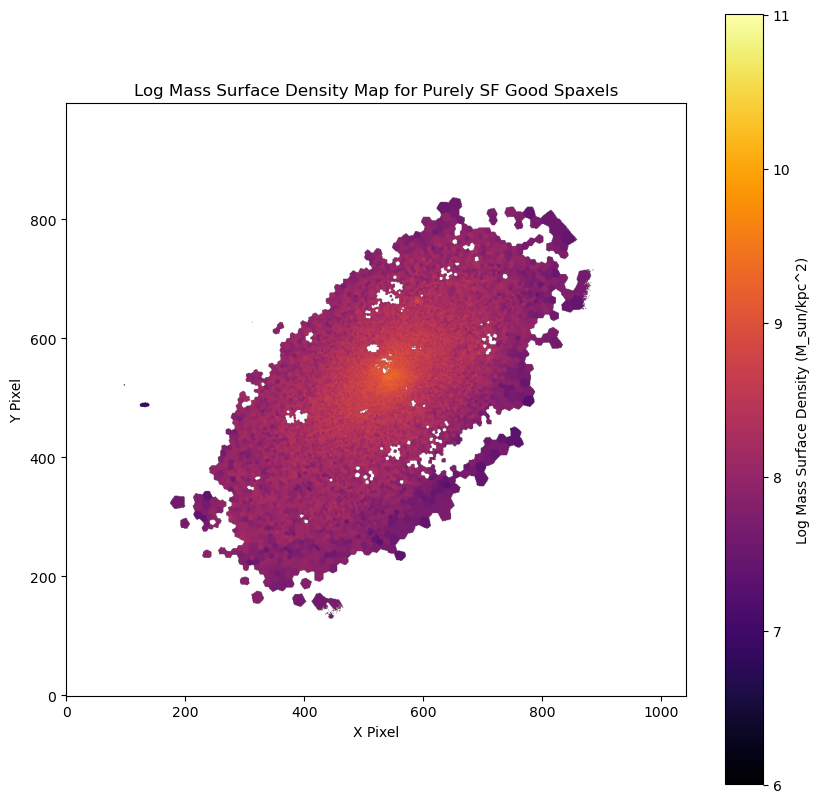

In [37]:
LOGMASS_SURFACE_DENSITY_SF_good = np.where(good, LOGMASS_SURFACE_DENSITY, np.nan)
plt.figure(figsize=(10, 10))
plt.imshow(LOGMASS_SURFACE_DENSITY_SF_good, origin='lower', cmap='inferno',
           vmin=6, vmax=11)
plt.colorbar(label='Log Mass Surface Density (M_sun/kpc^2)')
plt.title('Log Mass Surface Density Map for Purely SF Good Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

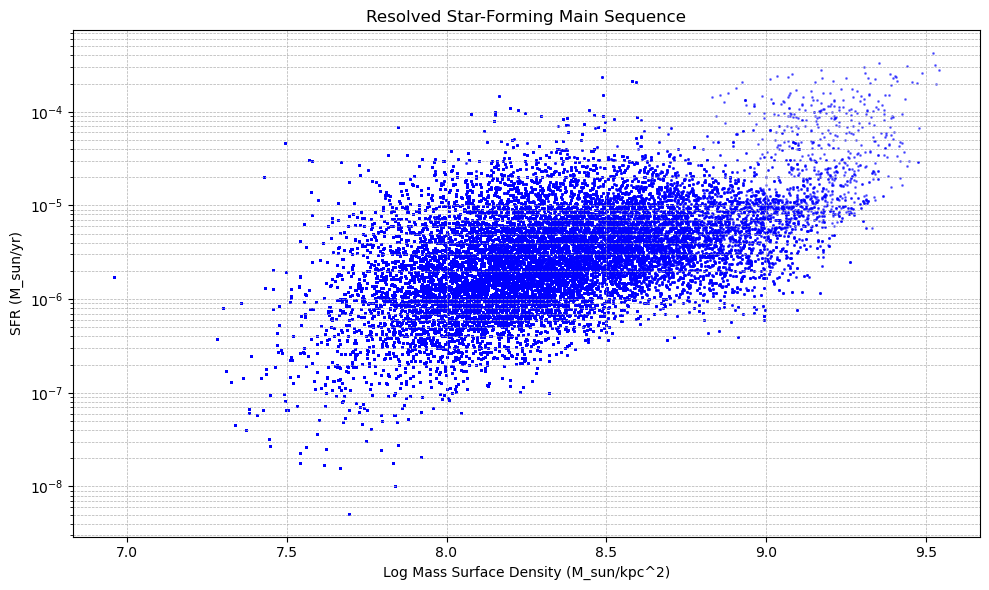

In [38]:
# Plot the resolved SFMS plot
plt.figure(figsize=(10, 6))
plt.scatter(LOGMASS_SURFACE_DENSITY_SF_good,
            SFR_map_SF_good_corr, s=1, alpha=0.5, color='blue')
plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('SFR (M_sun/yr)')    
plt.title('Resolved Star-Forming Main Sequence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.tight_layout()
plt.show()